In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
from conllu import parse
from nltk import DependencyGraph
from string import punctuation
from collections import Counter

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#responses = []
#with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
#    for row in tqdm(thefile):
#        resp = json.loads(row)
#        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
#            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru. [Ссылка на данные](https://drive.google.com/open?id=1CPKtX5HcgGWRpzbWZ2fMCyqgHGgk21l2).

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
#len(responses)

In [5]:
#banks = pd.DataFrame(responses)
#banks.info()

In [6]:
#banks = banks.iloc[::3]
#banks.info()

#banks.to_csv("banks_light.csv")

In [7]:
banks = pd.read_csv('banks_light.csv')
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51167 entries, 0 to 51166
Data columns (total 11 columns):
Unnamed: 0            51167 non-null int64
author                51160 non-null object
bank_license          51166 non-null object
bank_name             51167 non-null object
city                  46105 non-null object
datetime              51167 non-null object
num_comments          51167 non-null int64
rating_grade          29531 non-null float64
rating_not_checked    51167 non-null bool
text                  51167 non-null object
title                 50749 non-null object
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 4.0+ MB


## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах (не обязательно)
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривую Ципфа
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [8]:
city_top = banks.groupby(['city']).size().sort_values(ascending=False).reset_index()
city_top.head()

,city,0
0,г. Москва,18314
1,г. Санкт-Петербург,4801
2,г. Новосибирск,759
3,г. Екатеринбург,756
4,г. Нижний Новгород,692


In [9]:
bank_top = banks.groupby(['bank_name']).size().sort_values(ascending=False).reset_index()
bank_top.head()

,bank_name,0
0,Сбербанк России,8833
1,Альфа-Банк,3428
2,ВТБ 24,2759
3,Хоум Кредит Банк,2585
4,Русский Стандарт,2577


In [10]:
#тексты отзывов
text = banks.text.str.lower()
#text = text.apply(lambda x: regex.findall(x))

In [11]:
text = text.tolist()
#import re
#text = [re.sub(r'[^\w]', '', i) for i in text]

In [12]:
text = [i.split(' ') for i in text]

In [13]:
text = list(filter(None, text))

In [14]:
flatList = []
for i in text:
    flatList.extend(i)
    
text = flatList

In [15]:
text = [re.sub(r'[^\w]', '', i) for i in text]

In [16]:
text = list(filter(None, text))

In [22]:
counter = Counter()
counter.update(text)
counter.most_common(10)

[('в', 440373),
 ('и', 351833),
 ('не', 284356),
 ('на', 235918),
 ('что', 207309),
 ('я', 192452),
 ('с', 151414),
 ('по', 120823),
 ('мне', 107202),
 ('банка', 87959)]

In [23]:
print('"Сотрудник" -', counter['сотрудник'], 'appears frequently than "Клиент" -', counter['клиент'])

"Сотрудник" - 10420 appears frequently than "Клиент" - 5818


In [24]:
print('"мошенничество" -',counter['мошенничество'], '   "доверие" -',counter['доверие'])

"мошенничество" - 384    "доверие" - 394


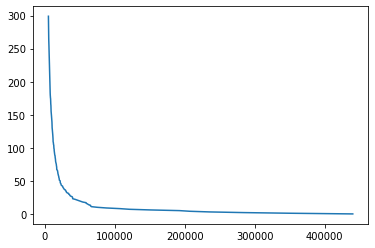

In [25]:
freqs = list(counter.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    * 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
    * 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 


Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

clf = Pipeline([
     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
     ('clf', RandomForestClassifier()),
 ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined

## Бонус [20]

Используйте для классификации эмбеддинги слов. Улучшилось ли качество?